In [1]:
import numpy as np
import skimage.filters as filters
import skimage.io as io
import skimage.transform as transform
import matplotlib.pyplot as plt
import cv2
import math
import os

In [2]:
#apply a gaussian filter
def smooth_image(original_image, sig):
    return filters.gaussian(original_image, sigma=sig)

In [3]:
#apply a threshold to the smoothed image
def otsu_threshold(smoothed_image):
    # Apply Otsu thresholding
    thresh = filters.threshold_otsu(smoothed_image)

    # Generate binary image
    binary = smoothed_image > thresh

    #convert to unsigned int
    thresholded = binary.astype(np.uint8)
    
    return thresholded
    

In [4]:
#close gabs in the hand
def close_holes(thres_image, kernel_size):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size) # size of kernel expected maximum area of a hole
    closed = cv2.morphologyEx(thres_image, cv2.MORPH_CLOSE, kernel)
    return closed

In [5]:
#find all contours in the image and return only the one that respresents the hand
def find_contours_and_return_hand_contour(filled_image):
    contours, _ = cv2.findContours(filled_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Filter contours on the original image 
    # since threre are no other objects in our image , we can ignore this step since the image will have only one contour (the hand)
    filtered_contours = max(contours, key=cv2.contourArea)
    
    return filtered_contours

In [6]:
#compute convex hull and defects
def convex_hull_and_defect(hand_contour):
    convex_hull = cv2.convexHull(hand_contour, returnPoints=False)
    defects = cv2.convexityDefects(hand_contour, convex_hull)
    return convex_hull, defects

In [7]:
#Calculate the angle between three points
def calculate_angle(start, farthest, end):
    vector1 = [farthest[0] - start[0], farthest[1] - start[1]]
    vector2 = [farthest[0] - end[0], farthest[1] - end[1]]
    
    dot_product = vector1[0] * vector2[0] + vector1[1] * vector2[1]
    magnitude_product = math.sqrt(vector1[0]**2 + vector1[1]**2) * math.sqrt(vector2[0]**2 + vector2[1]**2)
    
    if magnitude_product == 0:
        return 0
    
    cos_angle = dot_product / magnitude_product
    angle_rad = math.acos(cos_angle)
    angle_deg = math.degrees(angle_rad)
    
    return angle_deg

In [8]:
#count fingers
def count_fingers(hand_contour, defects):
    hand_area = cv2.contourArea(hand_contour)
    count_fingers = 0
    if hand_area > 1371:
        count_fingers = 1
        if defects is not None:
            for i in range(len(defects)):
                start, end, _, _ = defects[i, 0]
                start_point = tuple(hand_contour[start][0])
                end_point = tuple(hand_contour[end][0])
                farthest_point = tuple(hand_contour[defects[i, 0][2]][0])

                # Filter out defects based on depth and angle
                depth = defects[i, 0][3] / 256
                angle = calculate_angle(start_point, farthest_point, end_point)
                if depth > 20 and angle < 90:
                    count_fingers += 1
                
    return count_fingers

In [9]:
def process_and_count_fingers(ori_image):
    # Load the image
    original_image = ori_image
    
    # Apply Gaussian filter
    sigma=1
    smoothed_image = smooth_image(original_image, sigma)  # Adjust sigma as needed

    # Apply Otsu thresholding
    thresholded_image = otsu_threshold(smoothed_image)

    #close gabs in the hand
    kernel_size=(5,5)
    closed_image = close_holes(thresholded_image, kernel_size)

    # Filter contours on the original image 
    # since threre are no other objects in our image , we can ignore this step since the image will have only one contour (the hand)
    filtered_contours = find_contours_and_return_hand_contour(closed_image)

    #compute convex hull and defects
    convex_hull, defects = convex_hull_and_defect(filtered_contours)

    #count number of fingers in the image
    fingers_count= count_fingers(filtered_contours, defects)

    return fingers_count

In [10]:
def load_images():
    dire_path="./dip_project_images"
    images=[]
    labels=[]
    for filename in os.listdir(dire_path):
        image_path = os.path.join(dire_path, filename)
        
        image = io.imread(image_path, as_gray=True)
        label = filename[-6]
        images.append(image)
        labels.append(label)
        
    return np.array(images), np.array(labels).astype(int)

In [11]:
def compute_accuracy(images, labels):
    images_count=len(images)
    correctly_predicted=0
    for i, image in enumerate(images):
        fingers_count = process_and_count_fingers(image)
        
        if labels[i] == fingers_count:
            correctly_predicted+=1
    accuracy=(correctly_predicted/images_count)*100
    
    return accuracy

In [12]:
def plot(original_image, actual_label,predicted_label):
    print("Actual   : ", actual_label)
    print("Predicted: ", predicted_label)
    plt.figure()
    plt.imshow(original_image, cmap='gray')
    plt.title('Original image')
    plt.show()

In [13]:
#load 210 images with their labels
images, labels= load_images()

In [14]:
#calculate accuracy on the whole dataset
accuracy = compute_accuracy(images, labels)
print(accuracy)

75.23809523809524


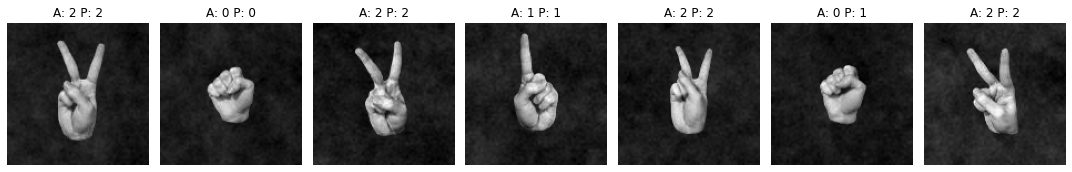

In [15]:
# plot images and the corresponding label as well as the predicted label
# A : actual label
# B : predicted label
fig, axes = plt.subplots(1, len(images[2:9]), figsize=(15, 15))
for i, image in enumerate(images[2:9]):
    pred_label = process_and_count_fingers(image)
    title_ = "A: {} P: {}".format(labels[2+i], pred_label)
    axes[i].set_title(title_)
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Actual   :  4
Predicted:  4


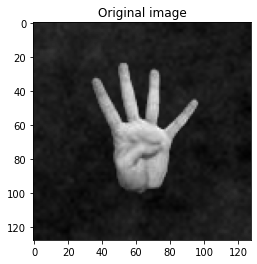

In [16]:
# choose an image to test the approach with by set image_number to any value between 0 - 209
image_number=40 # set to any value betwween 0 - 209
original_image = images[image_number]
original_label = labels[image_number]

#counts the fingers and plot the original image with labels : actual label and predicted label
predicted_label = process_and_count_fingers(original_image)
plot(original_image, original_label,predicted_label)